# Setups, Installations and Imports

In [ ]:
%%capture
!pip install tensorflow-gpu==2.0

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [ ]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid


import random

random.seed(10)

# Prepare Dataset

In [ ]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

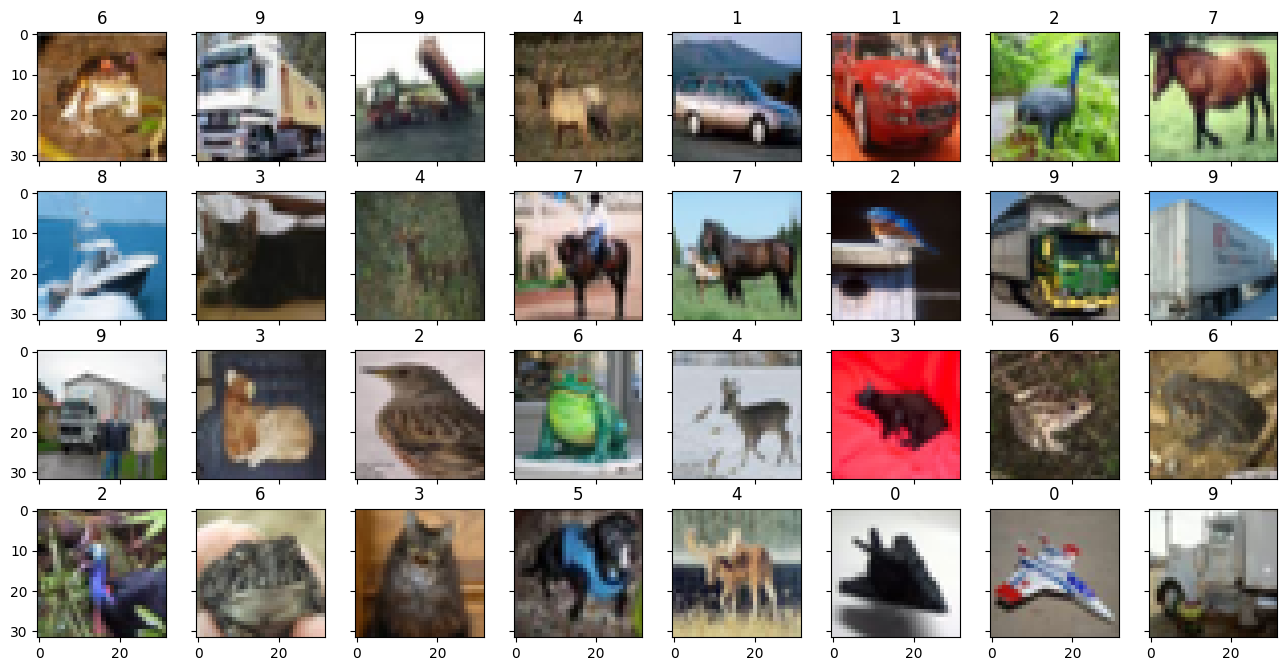

In [ ]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=False):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()

      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255

    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
## Prepare training and testing mask-image pair generator
traingen1 = createAugment(x_train, x_train)
testgen1 = createAugment(x_test, x_test)

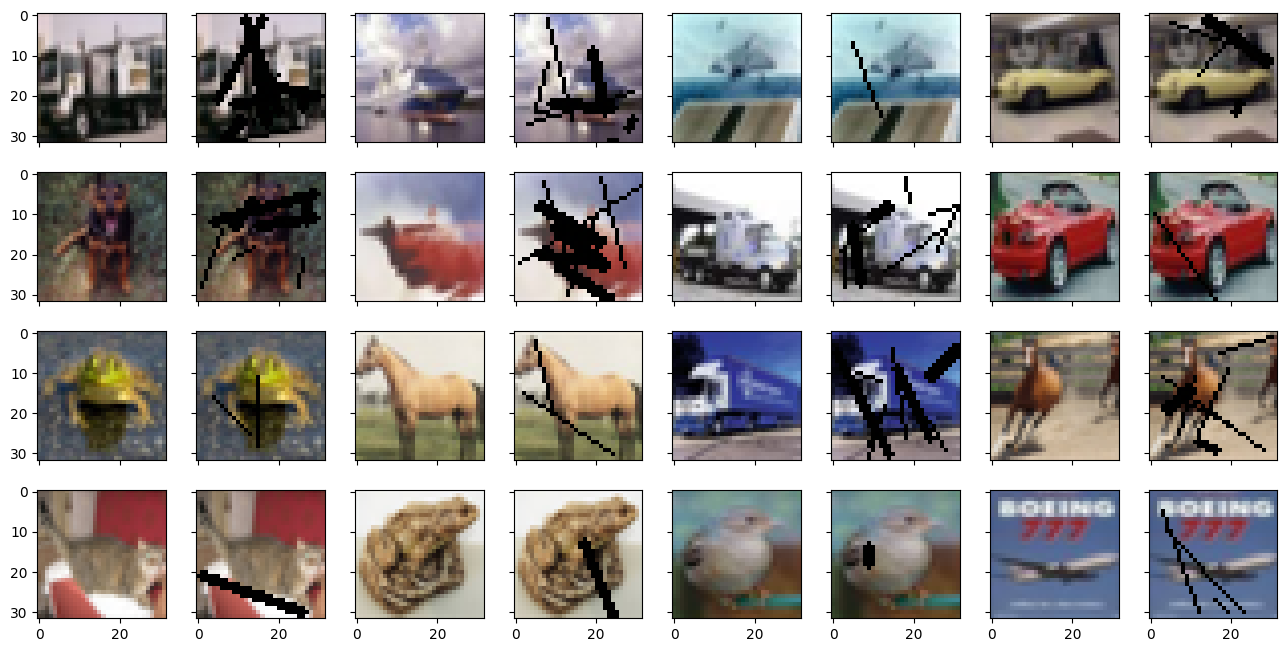

In [ ]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen1[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()


## Autoencoder-Decoder Model

In [ ]:

## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)

    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up


In [ ]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

## Train

In [ ]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        sample_images, sample_labels = testgen1[sample_idx]

        images = []
        labels = []
        predictions = []

        for i in range(32):
            inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

            images.append(sample_images[i])
            labels.append(sample_labels[i])
            predictions.append(inpainted_image.reshape(inpainted_image.shape[1:]))

In [ ]:
_ = model.fit(traingen1,
          validation_data=testgen1,
          epochs=20,
          steps_per_epoch=len(traingen1),
          validation_steps=len(testgen1),
          use_multiprocessing=True,
          callbacks= PredictionLogger())

Epoch 1/20
   4/1562 [..............................] - ETA: 52:21 - loss: 0.0662 - dice_coef: 0.6071

Process Keras_worker_ForkPoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

## Testing on images

In [ ]:
## Examples
rows = 32
sample_idx = 54
sample_images, sample_labels = testgen1[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=False):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))


  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image


    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()

      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)

      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [ ]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

In [ ]:
# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

gvgcfcccfcf60

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        '''

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

AssertionError: ignored

In [ ]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')

    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])

  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

In [ ]:
keras.backend.clear_session()
model1 = InpaintingModel().prepare_model()
# model.summary()
model1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model1, show_shapes=True, dpi=60, to_file='model_v2.png')

# Train

In [ ]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]

        m_images = []
        binary_masks = []
        predictions = []
        labels = []

        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model1.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

In [ ]:
_ = model1.fit_generator(traingen, validation_data=testgen,
          epochs=20,
          steps_per_epoch=len(traingen),
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=PredictionLogger())

# Testing on images

In [ ]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth

## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model1.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])

plt.show()